In [153]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub/prj_on_boarding/")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub/prj_on_boarding


# 1. data load

In [154]:
df = pd.read_csv("/Users/yj.noh/Desktop/rfm_data.csv", encoding = "cp949")
print(df.isna().sum())
print(df.shape) #24,201 

brms_rider_id          0
work_start_week        0
recency               28
working_cycle         28
avg_daily_delivery    28
avg_day_income        28
avg_week_income       28
dtype: int64
(24201, 7)


In [155]:
df = df[df['avg_daily_delivery'].notnull()]
print(df.shape) # 24173

(24173, 7)


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24173 entries, 0 to 24200
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brms_rider_id       24173 non-null  object 
 1   work_start_week     24173 non-null  object 
 2   recency             24173 non-null  float64
 3   working_cycle       24173 non-null  float64
 4   avg_daily_delivery  24173 non-null  float64
 5   avg_day_income      24173 non-null  float64
 6   avg_week_income     24173 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.5+ MB


In [157]:
df.describe()

recency  working_cycle  avg_daily_delivery  avg_day_income  \
count  24173.000000   24173.000000        24173.000000    24173.000000   
mean      17.185289       2.359667            7.556199    35073.727682   
std       22.275579       2.574821            7.069497    34941.166192   
min        0.000000       1.000000            1.000000        0.000000   
25%        0.000000       1.000000            2.500000    10340.000000   
50%        6.000000       1.500000            5.166667    22590.000000   
75%       28.000000       2.500000           10.240000    47855.185185   
max       84.000000      39.500000           68.744681   317941.702128   

       avg_week_income  
count     2.417300e+04  
mean      1.145104e+05  
std       1.593741e+05  
min       0.000000e+00  
25%       1.583333e+04  
50%       4.959333e+04  
75%       1.431067e+05  
max       1.660362e+06

In [158]:
df['work_start_week'] = df['work_start_week'].astype('category')

ordered_cats = ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D',
               '10W1D', '10W2D', '10W3D', '10W4D', '10W5D']

df['work_start_week'] = df['work_start_week'].cat.reorder_categories(ordered_cats)


# 2. 데이터 탐색

## 2-1. numeric 변수 확인

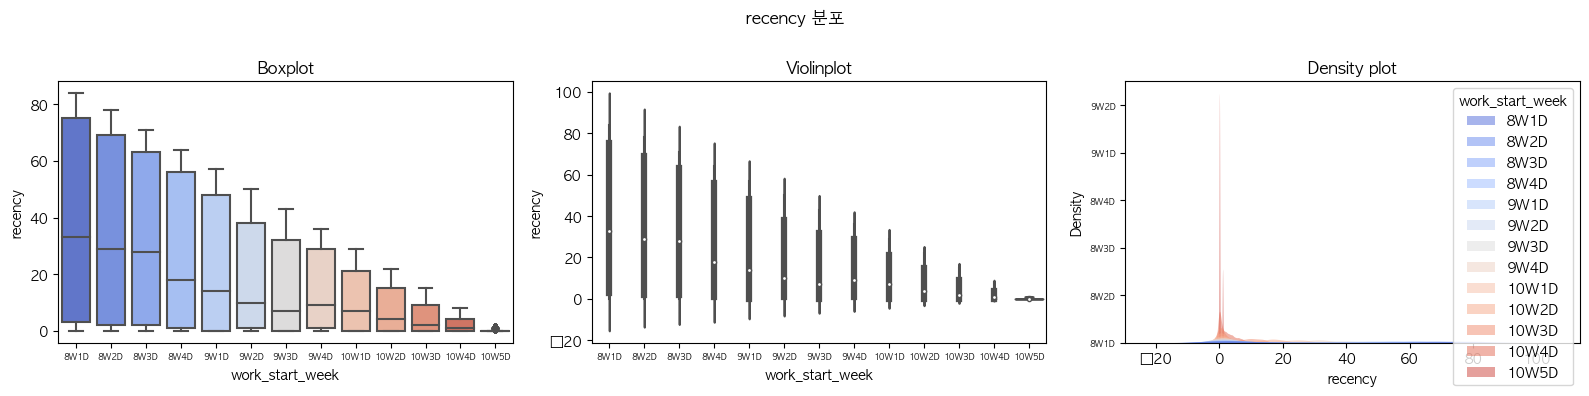

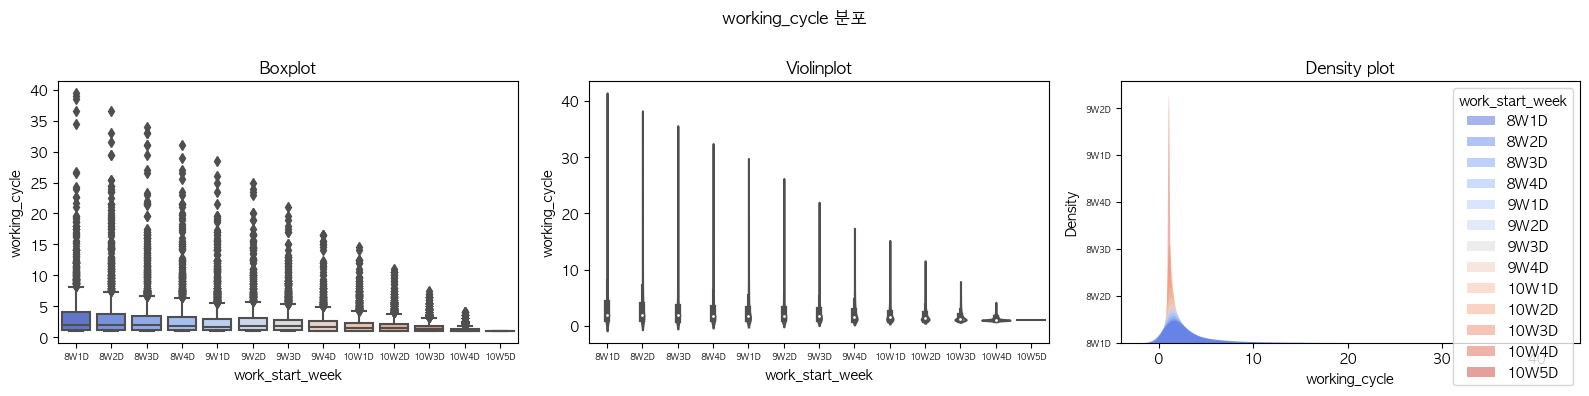

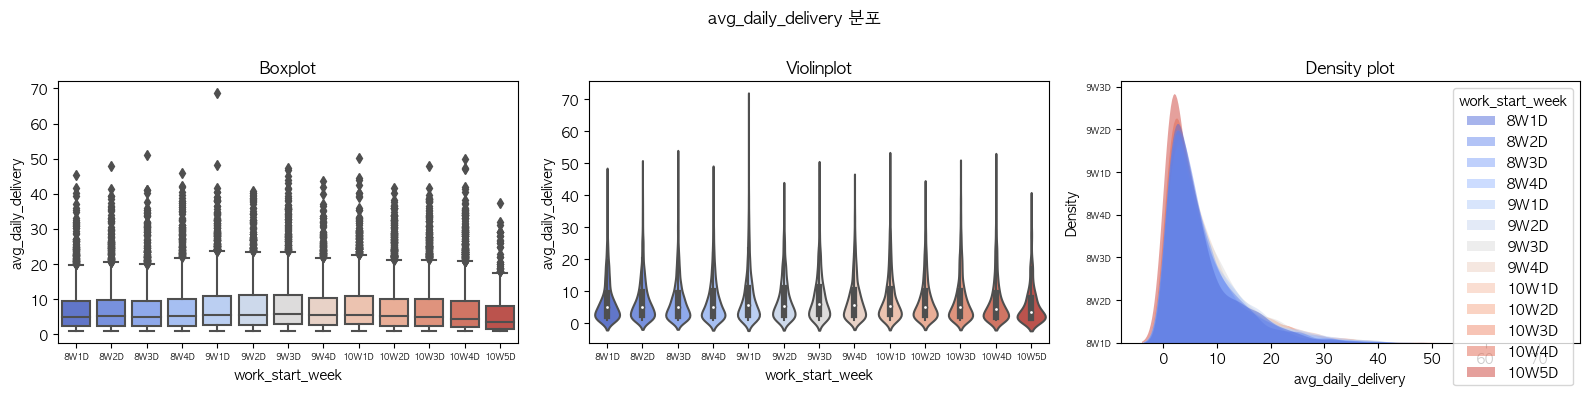

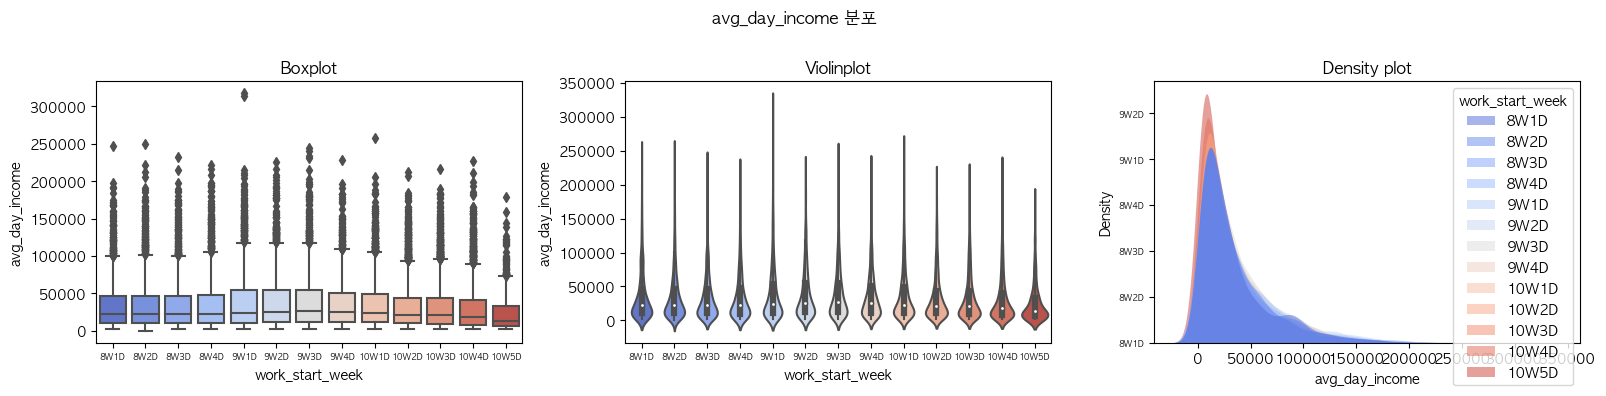

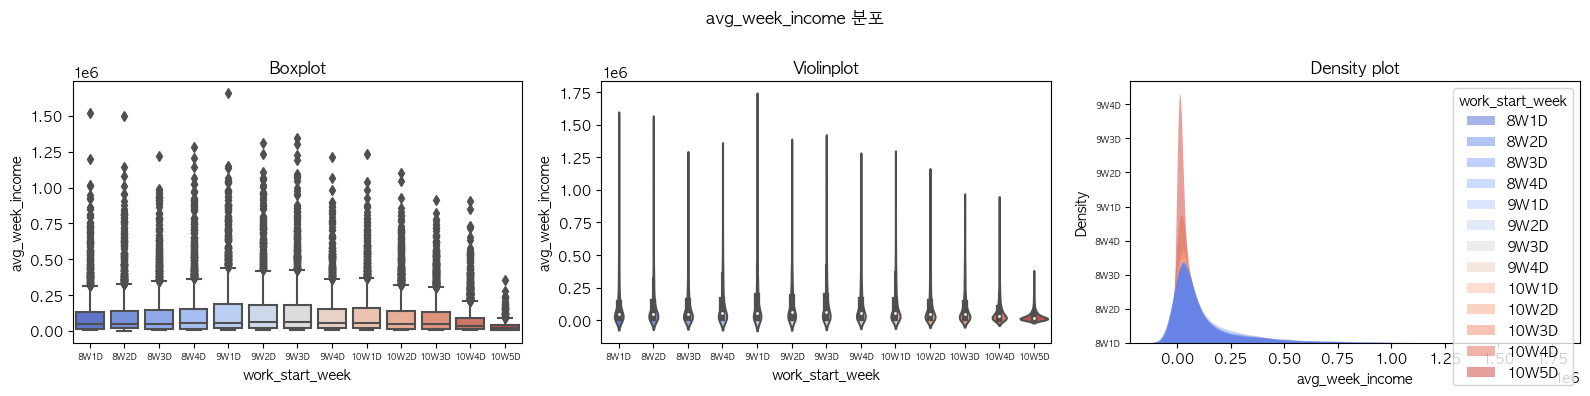

In [159]:
def plot_numeric (data, numeric_vars, outcome):
        
    palette = 'coolwarm'
    
    os.makedirs('rfm_graphs', exist_ok = True)
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(16,4))
        fig.suptitle(f'{num_var} 분포', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0],  x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_xticklabels(labels =  ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D','10W1D',  '10W2D', '10W3D', '10W4D','10W5D'],
                               fontsize =6)
        axs[0].set_title('Boxplot')
            
        # Violinplot
        sns.violinplot(ax=axs[1],  x= outcome, y = num_var, data = data, palette = palette)
        axs[1].set_xticklabels(labels =  ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D','10W1D',  '10W2D', '10W3D', '10W4D','10W5D'],
                               fontsize =6)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, fill = True, hue = outcome, common_norm = False, palette = palette, alpha=.5, linewidth=0, legend = True)
        axs[2].set_yticklabels(labels =  ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D','10W1D',  '10W2D', '10W3D', '10W4D','10W5D'],
                               fontsize =6)
        axs[2].set_title('Density plot')
        #axs[2].legend(fontsize='medium')
     
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        
        fig.savefig(f'rfm_graphs/{num_var}_distributions.png')
        plt.show()
        plt.close(fig)

numeric_vars = ['recency', 'working_cycle', 'avg_daily_delivery', 'avg_day_income', 'avg_week_income']
plot_numeric(df, numeric_vars, 'work_start_week')

## 2-2 boxplot 

In [160]:
def calculate_statistics(data, variable_name):
    Q1 = data[variable_name].quantile(0.25)
    median = data[variable_name].quantile(0.50)
    Q3 = data[variable_name].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    max_val = data[variable_name].max()

    return Q1, median, Q3, upper_bound, max_val

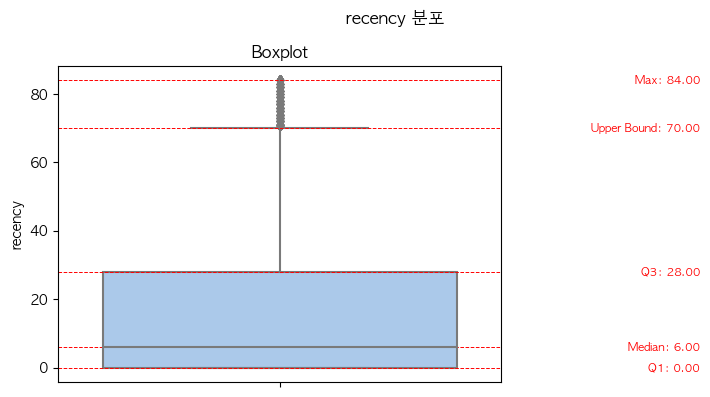

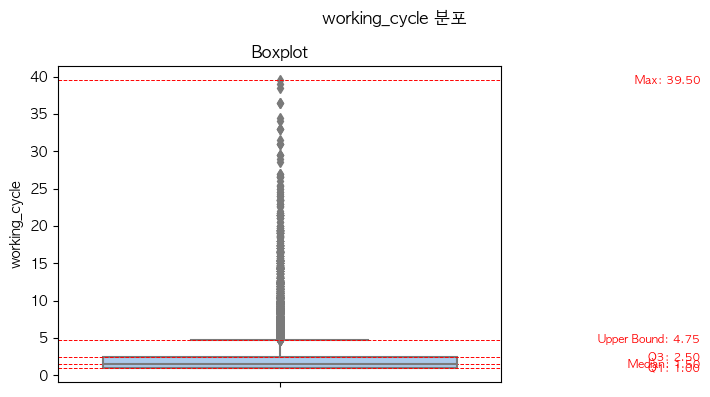

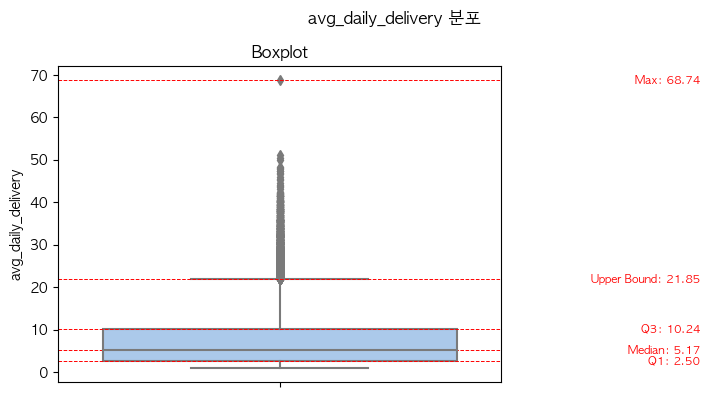

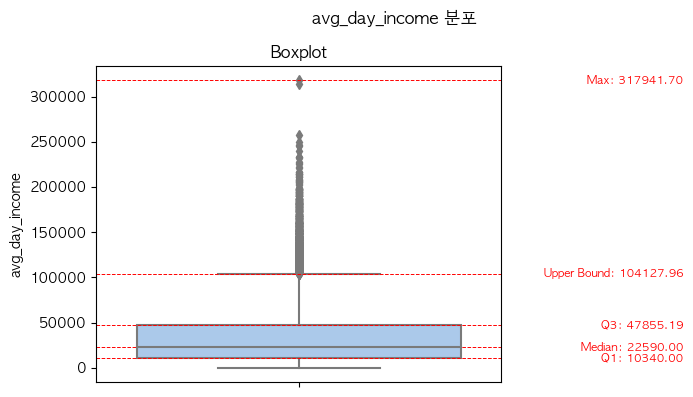

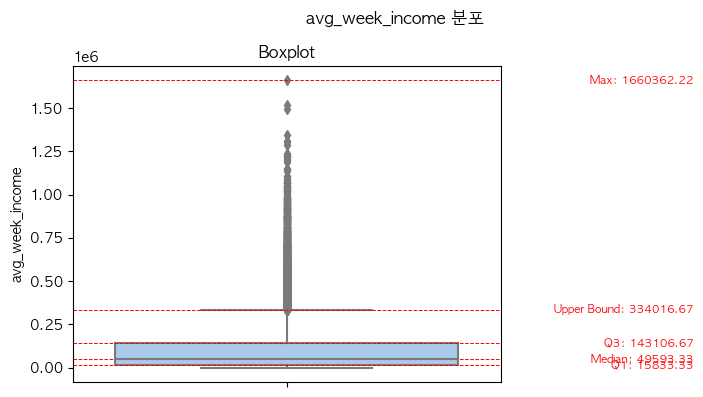

In [161]:
def box_plot_numeric(data, numeric_vars):        
    palette = 'pastel'
    os.makedirs('rfm_graphs', exist_ok=True)
    
    for num_var in numeric_vars:
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(f'{num_var} 분포', fontsize=12)
    
        # Boxplot
        sns.boxplot(y=num_var, data=data, palette=palette, ax=ax)
        ax.set_title('Boxplot')

        # Statistics for the numeric variable
        Q1, median, Q3, upper_bound, max_val = calculate_statistics(data, num_var)
        
        for value, label in zip([Q1, median, Q3, upper_bound, max_val], 
                                ['Q1', 'Median', 'Q3', 'Upper Bound', 'Max']):
            ax.axhline(y=value, color='r', linestyle='--', lw=0.7)
            ax.text(0.95, value, f"{label}: {value:.2f}", va='center', ha='right', color='r', fontsize=8)
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.84)
        
        fig.savefig(f'rfm_graphs/{num_var}_boxplot_before.png')
        plt.show()
        plt.close(fig)

numeric_vars = ['recency', 'working_cycle', 'avg_daily_delivery', 'avg_day_income', 'avg_week_income']
box_plot_numeric(df, numeric_vars)


## 2-3. density

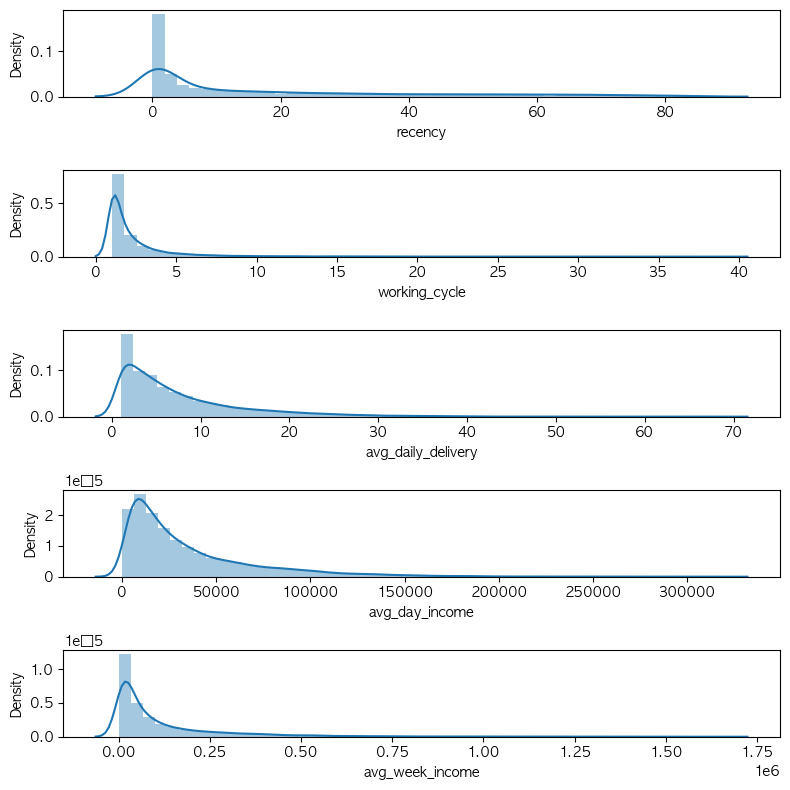

In [162]:
plt.figure(figsize=(8,8))

plt.subplot(5, 1, 1); sns.distplot(df['recency'])
plt.subplot(5, 1, 2); sns.distplot(df['working_cycle'])
plt.subplot(5, 1, 3); sns.distplot(df['avg_daily_delivery'])
plt.subplot(5, 1, 4); sns.distplot(df['avg_day_income'])
plt.subplot(5, 1, 5); sns.distplot(df['avg_week_income'])
plt.tight_layout()
plt.savefig('rfm_graphs/numeric_density_graph.png')
plt.show()

## 2-4. Pairplot

<Figure size 1000x800 with 0 Axes>

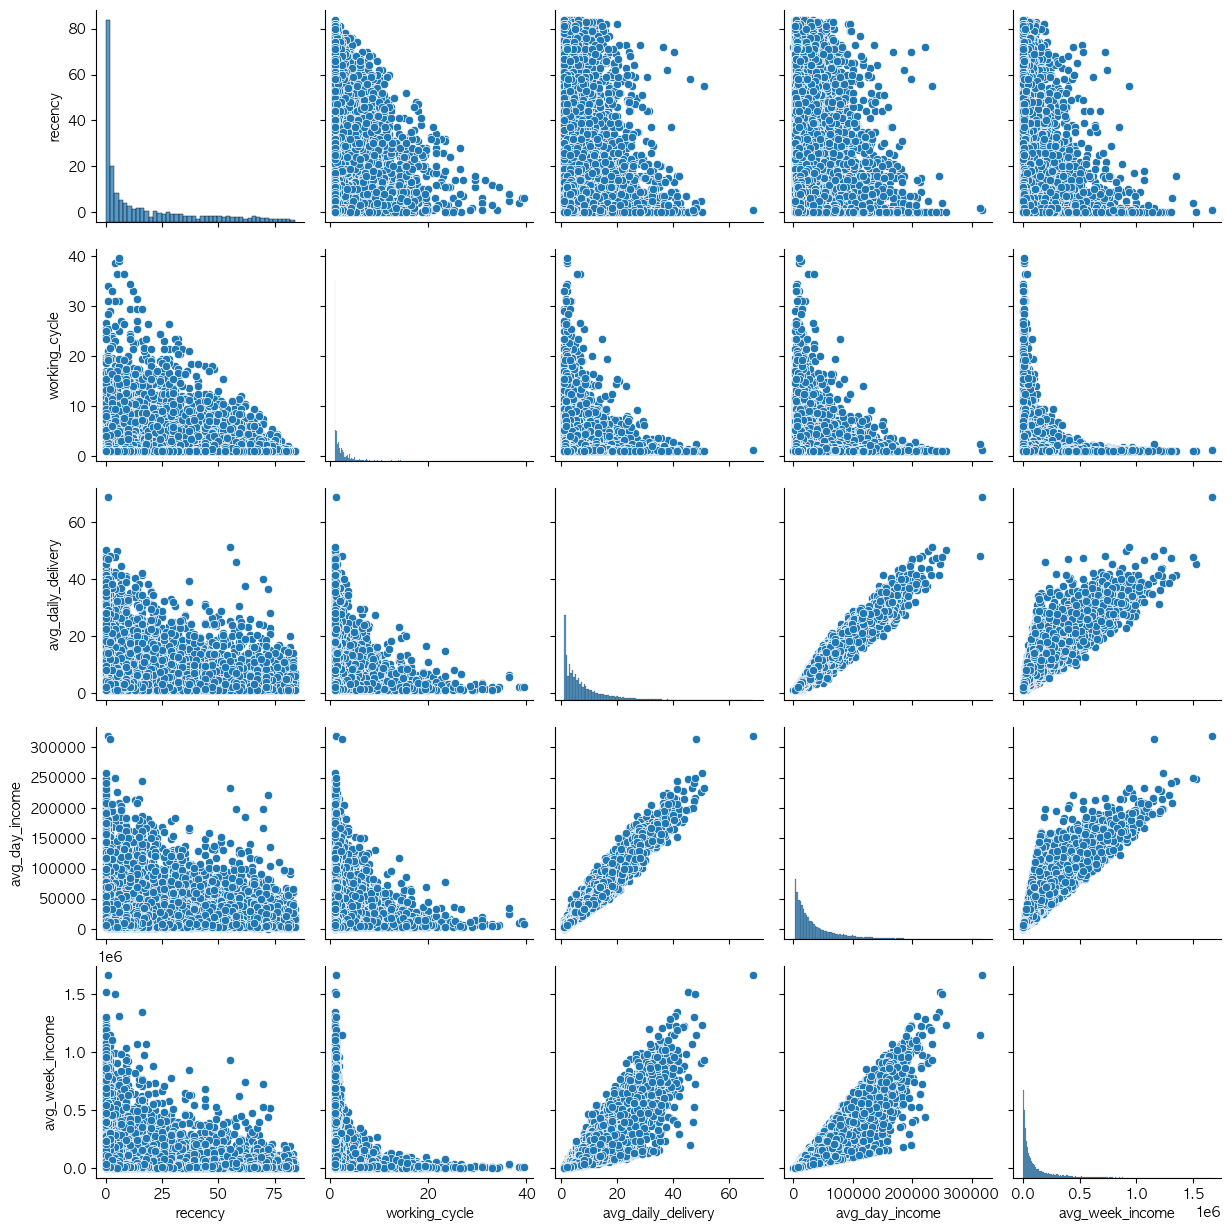

In [163]:
plt.figure(figsize = (10,8))
sns.pairplot(df[numeric_vars])
plt.savefig('rfm_graphs/pairplot.png')

## 2-5. Heatmap

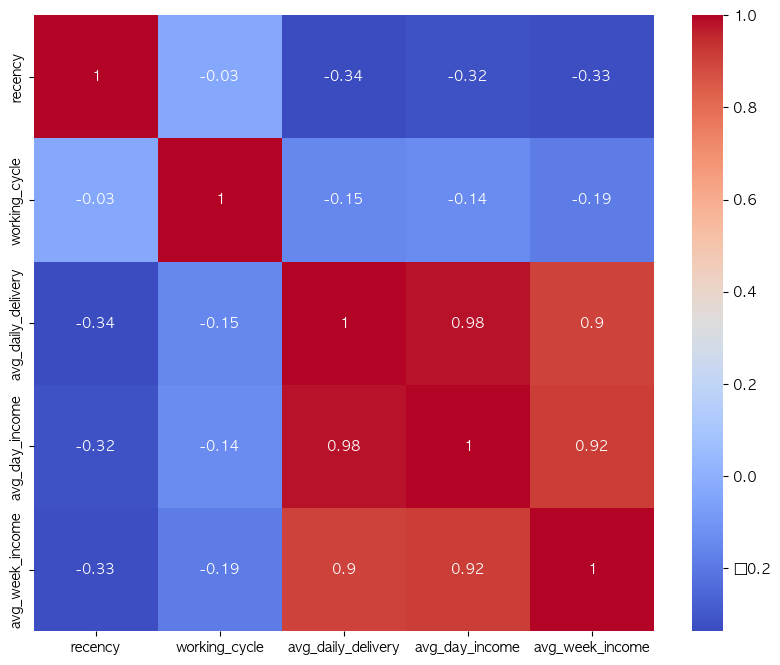

In [164]:
corr = df[numeric_vars].corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.savefig('rfm_graphs/heatmap.png')

## 2-6. 3차원 그래프 

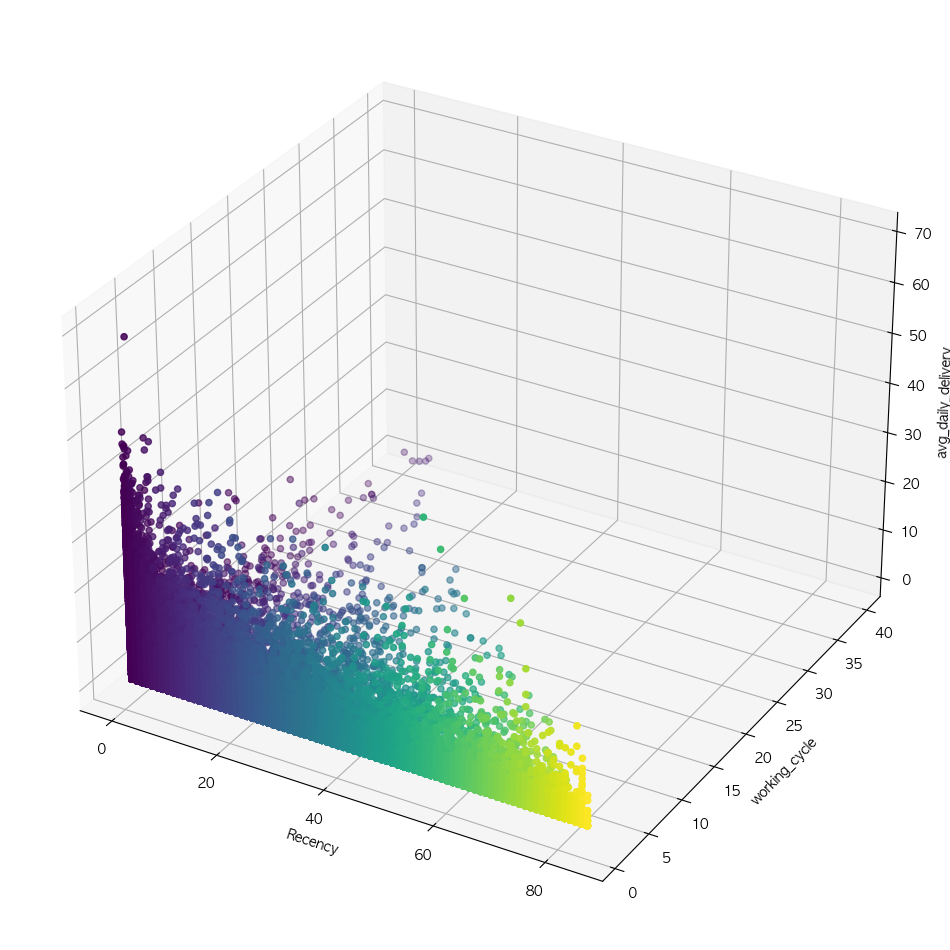

In [165]:
fig = plt.figure(figsize = (12,14))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(df['recency'], df['working_cycle'], df['avg_daily_delivery'], c = df['recency'], marker = 'o', cmap = 'viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('working_cycle')
ax.set_zlabel('avg_daily_delivery')

plt.savefig('rfm_graphs/third_graph.png')

## 2-7. Outlier 제거 

In [166]:
def remove_outliers(df, columns):

    for column in columns:

        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

df_outliers = remove_outliers(df, numeric_vars)


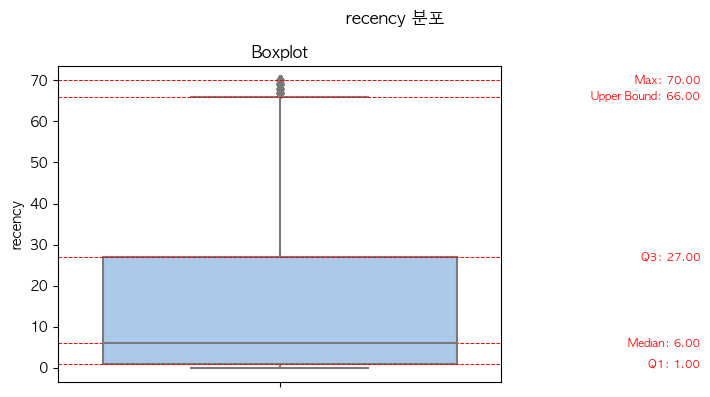

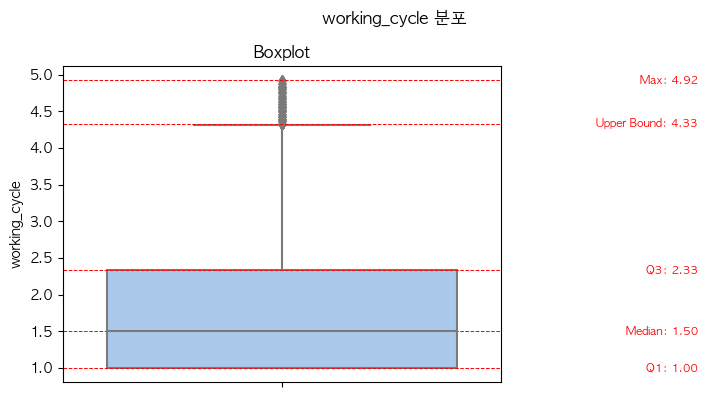

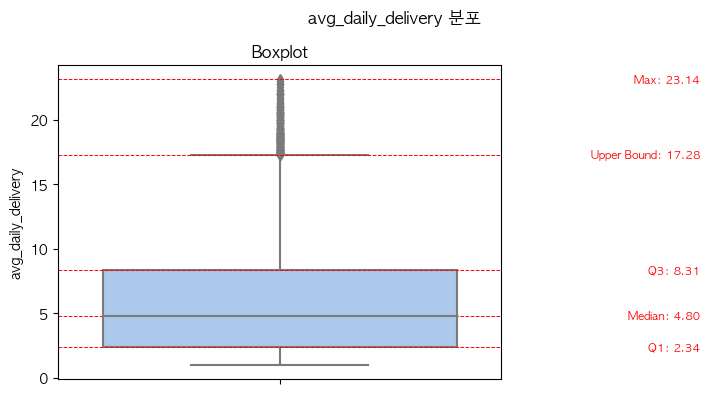

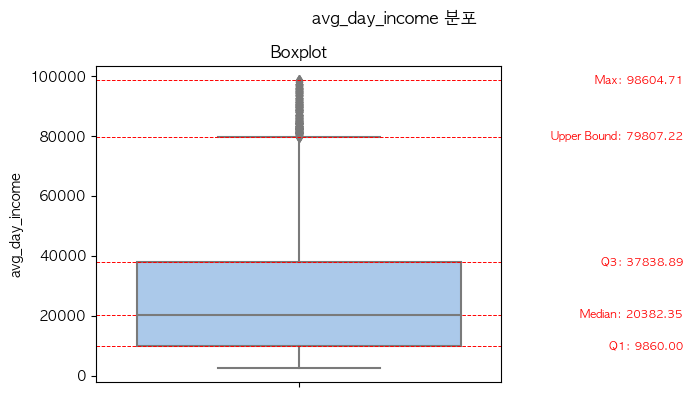

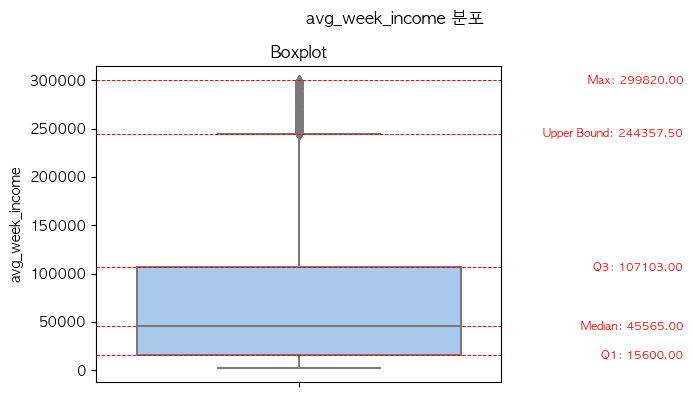

In [167]:
def box_plot_numeric_remove_outlier(data, numeric_vars):        
    palette = 'pastel'
    os.makedirs('rfm_graphs', exist_ok=True)
    
    for num_var in numeric_vars:
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(f'{num_var} 분포', fontsize=12)
    
        # Boxplot
        sns.boxplot(y=num_var, data=data, palette=palette, ax=ax)
        ax.set_title('Boxplot')

        # Statistics for the numeric variable
        Q1, median, Q3, upper_bound, max_val = calculate_statistics(data, num_var)
        
        for value, label in zip([Q1, median, Q3, upper_bound, max_val], 
                                ['Q1', 'Median', 'Q3', 'Upper Bound', 'Max']):
            ax.axhline(y=value, color='r', linestyle='--', lw=0.7)
            ax.text(0.95, value, f"{label}: {value:.2f}", va='center', ha='right', color='r', fontsize=8)
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.84)
        
        fig.savefig(f'rfm_graphs/{num_var}_boxplot_after.png')
        plt.show()
        plt.close(fig)

numeric_vars = ['recency', 'working_cycle', 'avg_daily_delivery', 'avg_day_income', 'avg_week_income']
box_plot_numeric_remove_outlier(df_outliers, numeric_vars)

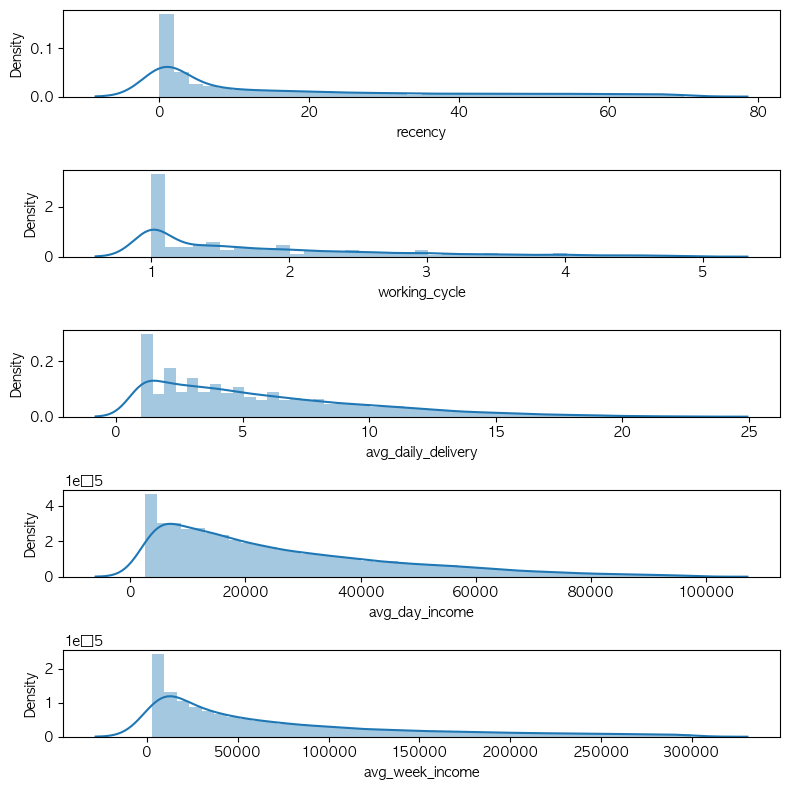

In [168]:
plt.figure(figsize=(8,8))

plt.subplot(5, 1, 1); sns.distplot(df_outliers['recency'])
plt.subplot(5, 1, 2); sns.distplot(df_outliers['working_cycle'])
plt.subplot(5, 1, 3); sns.distplot(df_outliers['avg_daily_delivery'])
plt.subplot(5, 1, 4); sns.distplot(df_outliers['avg_day_income'])
plt.subplot(5, 1, 5); sns.distplot(df_outliers['avg_week_income'])
plt.tight_layout()

plt.savefig(f'rfm_graphs/density_graph_after_outlier.png')
plt.show()

## 3. 데이터 정규화

## 3-1. 왜도 수정 
log transformation

square root transformation

box-cox transformation 

In [169]:
# 0은 로그, boxcox 치환이 안되므로, 0.001 모두 더하기 
def convert_from_zero (data, variable_names):
    for name in variable_names :
        data[name] = data[name].apply(lambda val: 0.001 if val == 0 else val)
    return data  

convert_from_zero(df_outliers, ['recency', 'avg_daily_delivery', 'working_cycle'])

brms_rider_id work_start_week  \
2      61DCD377479A8550EEA42404CAED40E1F95E2CA0CB25CA...            8W4D   
3      289C3DD67E62462ED43F9BFBF6C0324C0C3AFC39F14A71...           10W3D   
4      1ABBD7CD676CB2DC218BD85CCB009B357C4F6456CA5F54...           10W2D   
5      1F1A9EAFB8590E98CDC0417C41DDC7EDE4B9BA47FCA92C...            9W3D   
9      D2B47E3B0E121B12212FB50B9884DC84E66913D753DFAD...            8W1D   
...                                                  ...             ...   
24195  0788601A0A834D758EA980651F500E7FBB0F902556FAE3...           10W4D   
24196  AD5DBA3ECCA6997589DC78ABE294E0D411DEC9FCD9B688...           10W4D   
24198  D85212A3AB85407E2344A6F2599FC02C34464F0E41BB93...           10W4D   
24199  8962A9D2F50B45EC7315E0164EBD0080307C3ADFA3AD90...           10W5D   
24200  D3936BE0B897292235E33C078263348D2842533D8492F2...           10W5D   

       recency  working_cycle  avg_daily_delivery  avg_day_income  \
2        0.001       1.523810            1.547619     5575.000000   
3       12.000       1.000000            1.500000     5555.000000   
4       22.000       1.000000            1.000000     3640.000000   
5        6.000       1.590909            9.500000    41821.818182   
9       51.000       4.833333            4.833333    26073.333333   
...        ...            ...                 ...             ...   
24195    4.000       1.000000            3.000000    11170.000000   
24196    5.000       1.000000            1.000000     2900.000000   
24198    2.000       1.000000            3.000000    11140.000000   
24199    0.001       1.000000            2.000000     7280.000000   
24200    0.001       1.000000            8.000000    32840.000000   

       avg_week_income  
2         23415.000000  
3         11110.000000  
4          3640.000000  
5        153346.666667  
9         39110.000000  
...                ...  
24195     11170.000000  
24196      2900.000000  
24198     11140.000000  
24199      7280.000000  
24200     32840.000000  

[18283 rows x 7 columns]

In [170]:
print(df_outliers['recency'].isnull().any())
print(df_outliers['recency'].dtypes)
print((df_outliers['recency'] <=0).any())

False
float64
False


In [171]:
def analyze_skewness(data, x_list):

    for x in x_list:
        fig, ax = plt.subplots(2, 2, figsize=(8, 5))
        
        sns.distplot(data[x], ax=ax[0,0])
        ax[0,0].set_title(f'Original Distribution of {x}')
        
        sns.distplot(np.log(data[x]), ax=ax[0,1])
        ax[0,1].set_title(f'Log Transformed {x}')
        
        sns.distplot(np.sqrt(data[x]), ax=ax[1,0])
        ax[1,0].set_title(f'Square Root Transformed {x}')
        
        sns.distplot(stats.boxcox(data[x])[0], ax=ax[1,1])
        ax[1,1].set_title(f'Box-Cox Transformed {x}')
        
        plt.tight_layout()
        plt.savefig(f'rfm_graphs/{x}_skewness_analysis.png')  # 그래프 저장
        plt.show()

        print(f'For {x}:')
        print('Log Transform : The skew coefficient of', data[x].skew().round(2), 'to', np.log(data[x]).skew().round(2))
        print('Square Root Transform : The skew coefficient of', data[x].skew().round(2), 'to', np.sqrt(data[x]).skew().round(2))
        print('Box-Cox Transform : The skew coefficient of', data[x].skew().round(2), 'to', pd.Series(stats.boxcox(data[x])[0]).skew().round(2))
        print('-'*50)


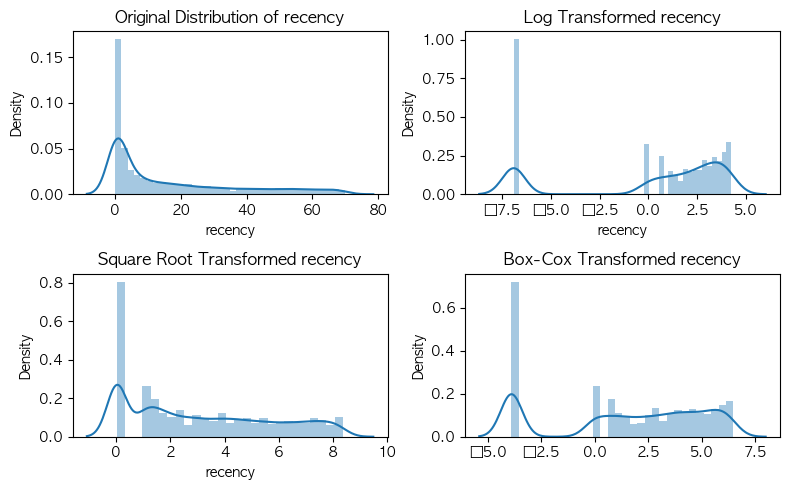

For recency:
Log Transform : The skew coefficient of 1.17 to -0.91
Square Root Transform : The skew coefficient of 1.17 to 0.45
Box-Cox Transform : The skew coefficient of 1.17 to -0.42
--------------------------------------------------


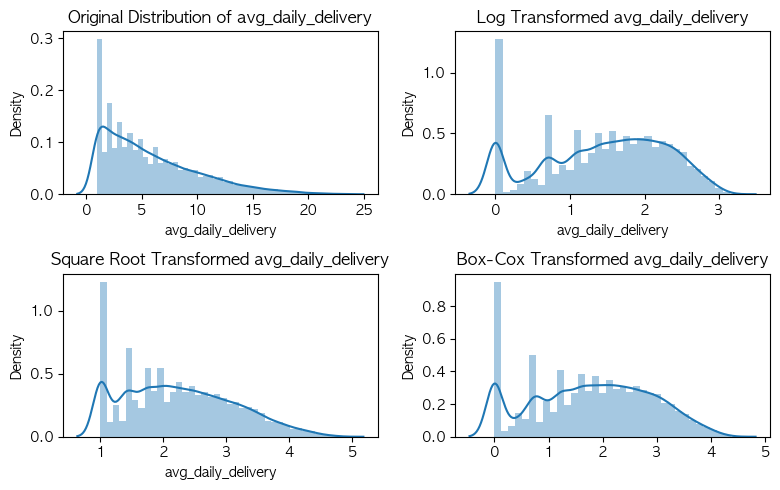

For avg_daily_delivery:
Log Transform : The skew coefficient of 1.02 to -0.31
Square Root Transform : The skew coefficient of 1.02 to 0.35
Box-Cox Transform : The skew coefficient of 1.02 to -0.05
--------------------------------------------------


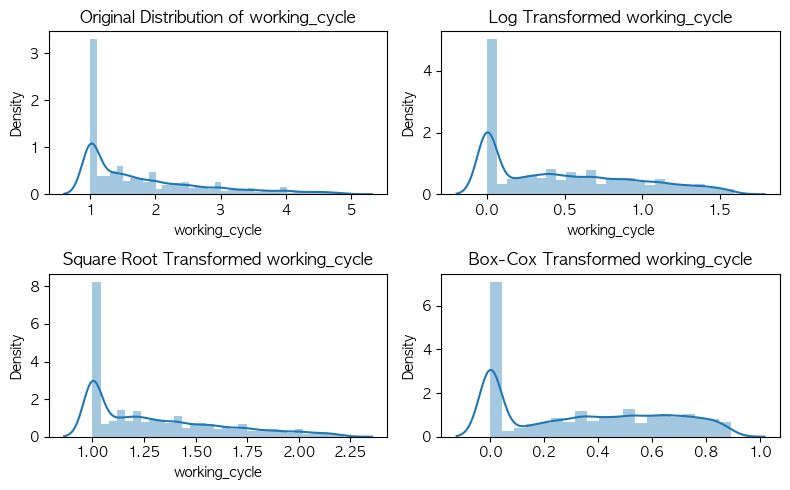

For working_cycle:
Log Transform : The skew coefficient of 1.22 to 0.58
Square Root Transform : The skew coefficient of 1.22 to 0.88
Box-Cox Transform : The skew coefficient of 1.22 to 0.18
--------------------------------------------------


In [172]:
analyze_skewness(df_outliers, ['recency', 'avg_daily_delivery', 'working_cycle'])

In [173]:
df_outliers['recency'] = stats.boxcox(df_outliers['recency'])[0]
df_outliers['avg_daily_delivery'] = stats.boxcox(df_outliers['avg_daily_delivery'])[0]
df_outliers['working_cycle'] = stats.boxcox(df_outliers['working_cycle'])[0]

df_outliers.tail()

brms_rider_id work_start_week  \
24195  0788601A0A834D758EA980651F500E7FBB0F902556FAE3...           10W4D   
24196  AD5DBA3ECCA6997589DC78ABE294E0D411DEC9FCD9B688...           10W4D   
24198  D85212A3AB85407E2344A6F2599FC02C34464F0E41BB93...           10W4D   
24199  8962A9D2F50B45EC7315E0164EBD0080307C3ADFA3AD90...           10W5D   
24200  D3936BE0B897292235E33C078263348D2842533D8492F2...           10W5D   

        recency  working_cycle  avg_daily_delivery  avg_day_income  \
24195  1.582234            0.0            1.227669         11170.0   
24196  1.877402            0.0            0.000000          2900.0   
24198  0.739998            0.0            1.227669         11140.0   
24199 -3.881265            0.0            0.743120          7280.0   
24200 -3.881265            0.0            2.574548         32840.0   

       avg_week_income  
24195          11170.0  
24196           2900.0  
24198          11140.0  
24199           7280.0  
24200          32840.0

## 3-2. scale

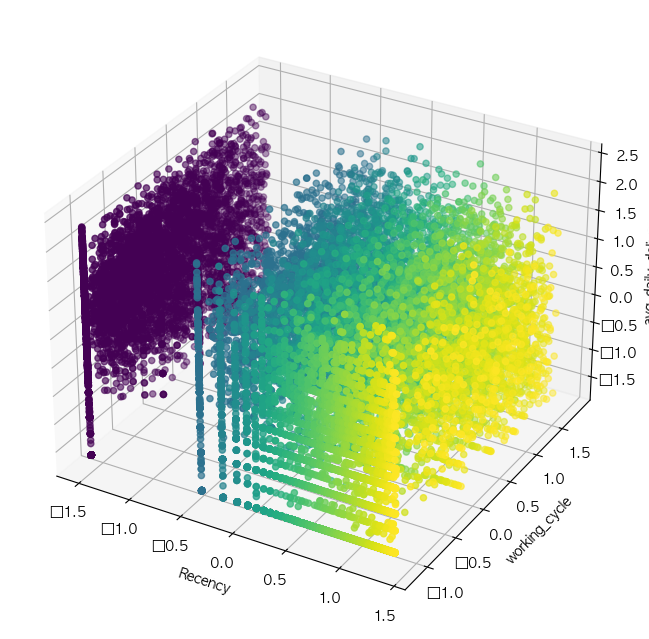

In [174]:

# scale
scaler = StandardScaler()
#scaler = MinMaxScaler()

df_s = scaler.fit_transform(df_outliers[numeric_vars])
scaled_df = pd.DataFrame(df_s, columns = numeric_vars, index = df_outliers.index)

# categorical_cols = [col for col in df.columns if col not in numeric_vars]
# df_cate = df[categorical_cols]

# scaled_df = pd.concat([df_scaled, df_cate], axis = 1)

fig = plt.figure(figsize = (8,10))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(scaled_df['recency'], scaled_df['working_cycle'], scaled_df['avg_daily_delivery'], c = scaled_df['recency'], marker = 'o', cmap = 'viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('working_cycle')
ax.set_zlabel('avg_daily_delivery')
plt.savefig(f'rfm_graphs/third_graph_after_scale.png')

## 3-3. 차원축소

In [175]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_df[['recency', 'avg_daily_delivery', 'working_cycle']])

reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
print(reduced_df)

            PC1       PC2
0      0.115343 -0.556704
1     -1.579585 -0.739263
2     -2.024115 -0.583333
3      0.607601  0.131501
4     -0.033913  2.159161
...         ...       ...
18278 -0.795711 -0.990582
18279 -1.621885 -0.872830
18280 -0.648743 -1.096360
18281 -0.148096 -1.644906
18282  1.007548 -1.765266

[18283 rows x 2 columns]


# 4. Clustering

## 4-1. DBSCAN - eps, min_samples 결정

In [176]:
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [3, 4, 5, 6, 7]
best_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(reduced_df)
        # -1 labels are noise in DBSCAN
        if len(set(clusters)) > 1:
            score = silhouette_score(reduced_df, clusters)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Optimal eps: {best_eps}, min_samples: {best_min_samples} for DBSCAN") # 0.1, 7 

Optimal eps: 0.1, min_samples: 7 for DBSCAN


## 4-2. KMeans의 K값 결정 

In [177]:
max_clusters = 10
sil_scores = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(reduced_df)
    sil_scores.append(silhouette_score(reduced_df, clusters))

optimal_clusters = sil_scores.index(max(sil_scores)) + 2

print(f"Optimal number of clusters for KMeans: {optimal_clusters}") #3

Optimal number of clusters for KMeans: 3


## 4-3. 계층적 클러스터링의 't'값 결정 

In [178]:
linked = linkage(reduced_df, method='ward')
max_t = 10
step = 0.5
t_values = np.arange(step, max_t, step)
best_score = -1

for t in t_values:
    clusters = fcluster(linked, t=t, criterion='distance')
    score = silhouette_score(reduced_df, clusters)
    if score > best_score:
        best_score = score
        best_t = t

print(f"Optimal t value for hierarchical clustering: {best_t}") #0.5

Optimal t value for hierarchical clustering: 0.5


## 4-4. 클러스터링 진행

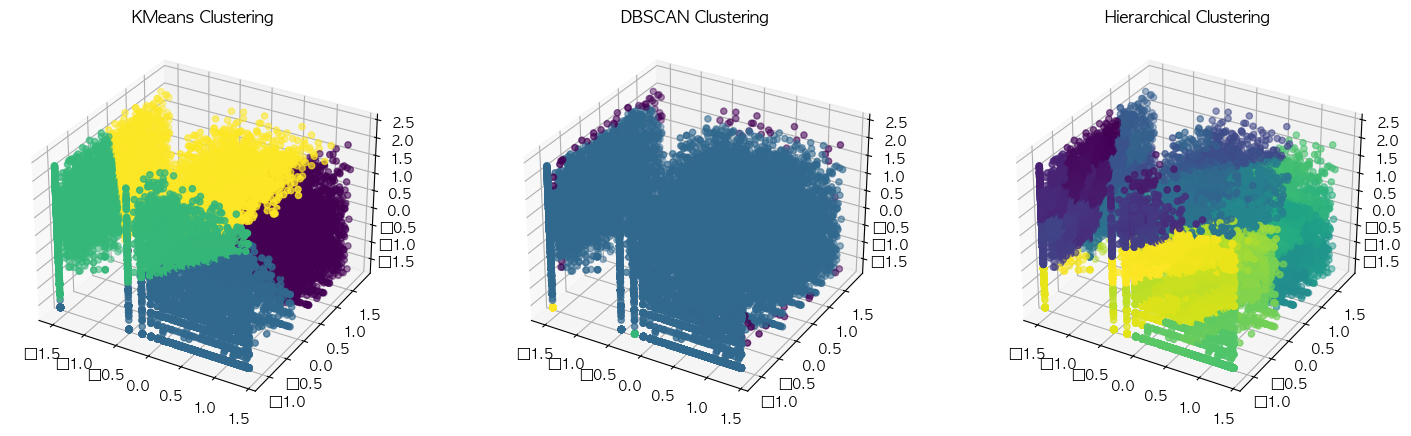

hierachical_cluster
409    207
411    197
422    154
414    154
417    142
      ... 
463      6
448      5
407      4
450      3
447      3
Name: count, Length: 573, dtype: int64


In [179]:

fig = plt.figure(figsize=(18, 5))

# KMeans Clustering
ax1 = fig.add_subplot(131, projection='3d')
kmeans = KMeans(n_clusters = 4)
clusters_kmeans = kmeans.fit_predict(reduced_df)

scaled_df['kmeans_cluster'] = clusters_kmeans

ax1.scatter(scaled_df['recency'], scaled_df['working_cycle'], scaled_df['avg_daily_delivery'], c = scaled_df['kmeans_cluster'], cmap='viridis')
ax1.set_title("KMeans Clustering")


# DBSCAN Clustering
ax2 = fig.add_subplot(132, projection='3d')
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters_dbscan = dbscan.fit_predict(reduced_df)

scaled_df['dbscan_cluster'] = clusters_dbscan

ax2.scatter(scaled_df['recency'], scaled_df['working_cycle'], scaled_df['avg_daily_delivery'], c = scaled_df['dbscan_cluster'], cmap='viridis')
ax2.set_title("DBSCAN Clustering")


# Hierarchical Clustering
ax3 = fig.add_subplot(133, projection='3d')
clusters_hierarchical = fcluster(linked, t= 0.5, criterion='distance')

scaled_df['hierachical_cluster'] = clusters_hierarchical
ax3.scatter(scaled_df['recency'], scaled_df['working_cycle'], scaled_df['avg_daily_delivery'], c = scaled_df['hierachical_cluster'], cmap='viridis')
ax3.set_title("Hierarchical Clustering")

plt.savefig(f'rfm_graphs/after_clustering.png')
plt.show()

print(scaled_df['hierachical_cluster'].value_counts())

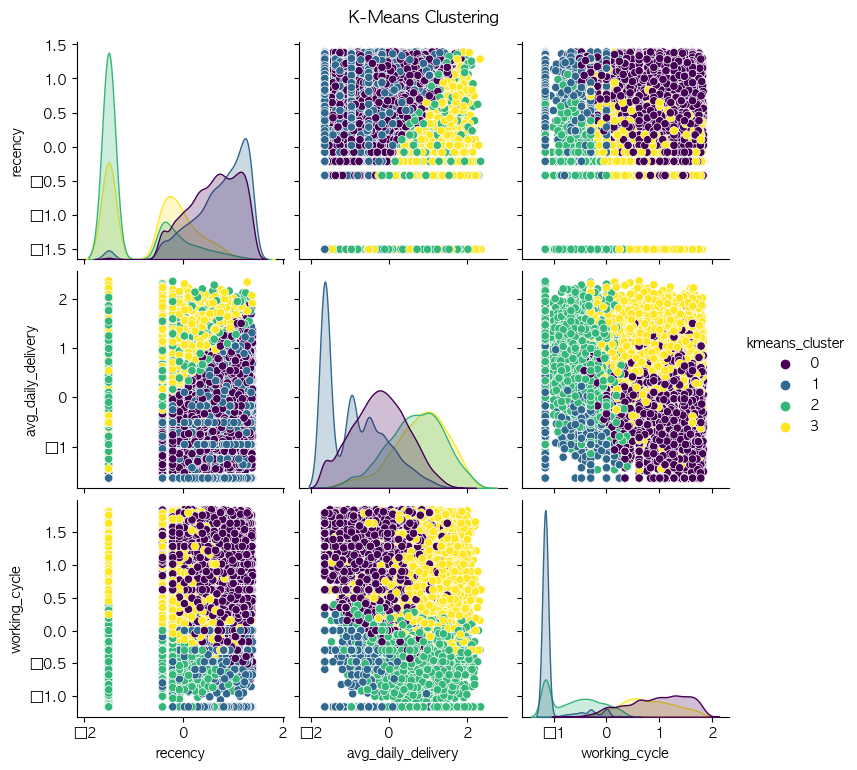

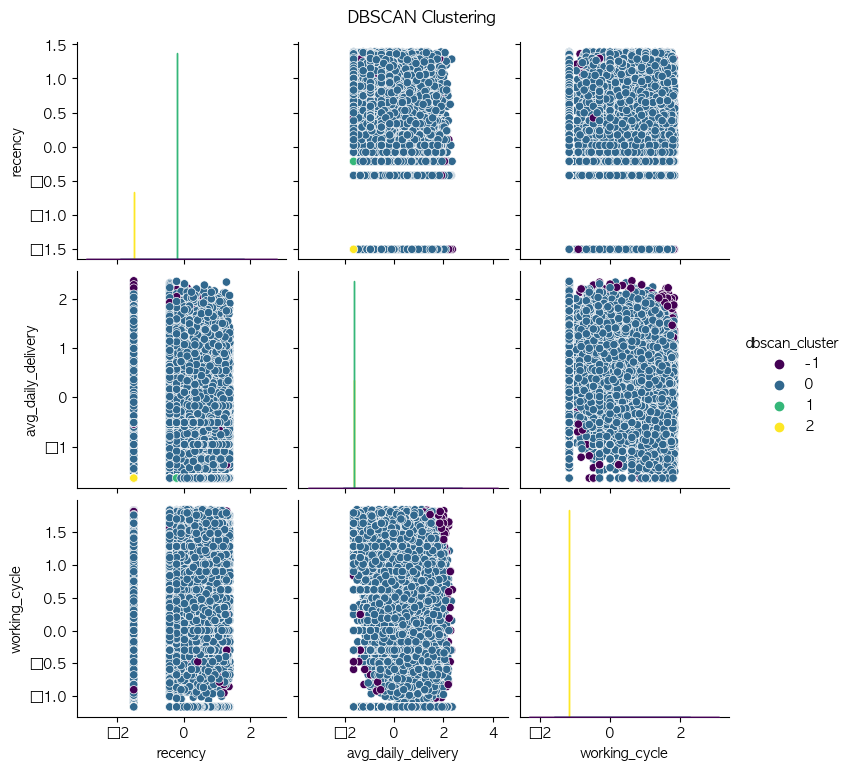

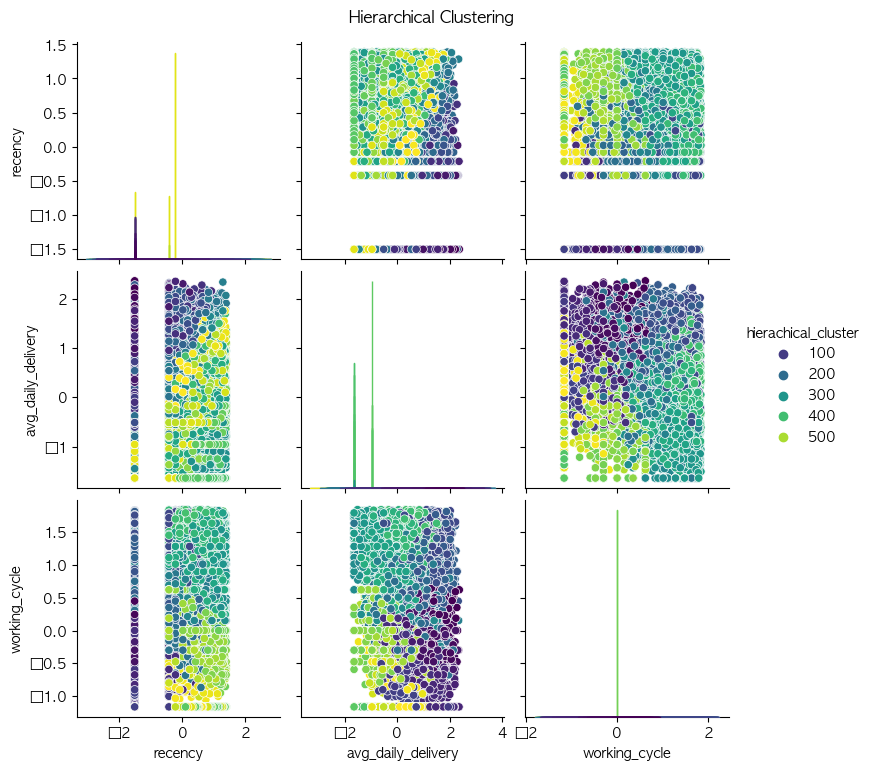

In [180]:
# k-means 
sns.pairplot(scaled_df[['recency', 'avg_daily_delivery','working_cycle', 'kmeans_cluster']], hue='kmeans_cluster', palette='viridis')
plt.suptitle('K-Means Clustering', y=1.02)
plt.savefig('rfm_graphs/kmeans_pairplot.png')
plt.show()

# DBSCAN 
sns.pairplot(scaled_df[['recency', 'avg_daily_delivery','working_cycle', 'dbscan_cluster']], hue='dbscan_cluster', palette='viridis')
plt.suptitle('DBSCAN Clustering', y=1.02)
plt.savefig('rfm_graphs/dbscan_pairplot.png')
plt.show()

# Hierarchical
sns.pairplot(scaled_df[['recency', 'avg_daily_delivery','working_cycle', 'hierachical_cluster']], hue='hierachical_cluster', palette='viridis')
plt.suptitle('Hierarchical Clustering', y=1.02)
plt.savefig('rfm_graphs/hierarchical_pairplot.png')
plt.show()

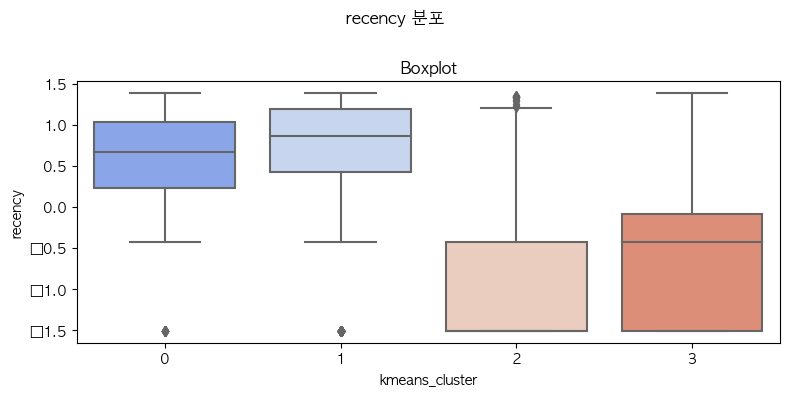

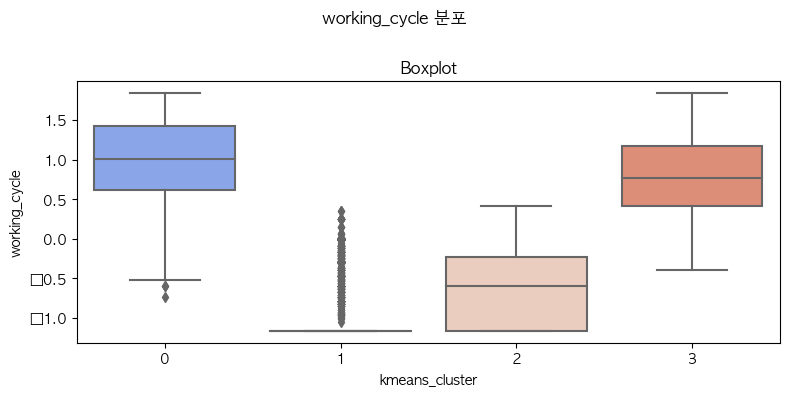

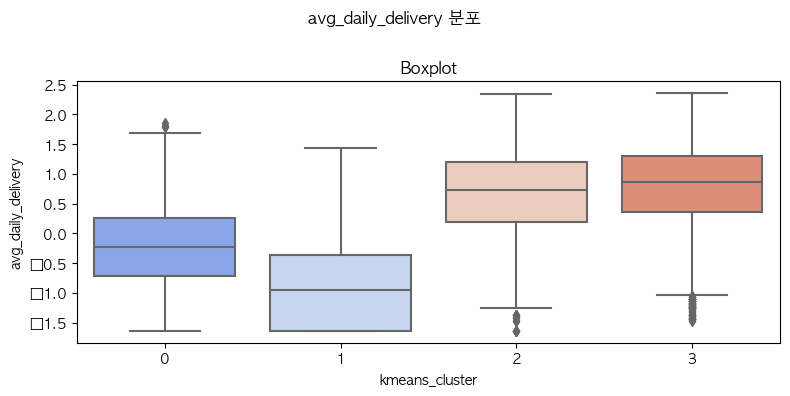

In [187]:
def plot_cluster (data, numeric_vars, outcome):
        
    palette = 'coolwarm'
    
    os.makedirs('rfm_graphs', exist_ok = True)
    
    for num_var in numeric_vars:
        fig, ax = plt.subplots(1,1, figsize=(8,4))
        fig.suptitle(f'{num_var} 분포', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=ax,  x= outcome, y=num_var, data= data, showfliers=True, palette = palette)
        ax.set_title('Boxplot')
     
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        fig.savefig(f'rfm_graphs/{num_var}_boxplot_cluster_group.png')
        plt.show()
        plt.close(fig)


numeric_vars = ['recency', 'working_cycle', 'avg_daily_delivery']
plot_cluster(scaled_df[['recency', 'working_cycle', 'avg_daily_delivery', 'kmeans_cluster']], numeric_vars, 'kmeans_cluster')

In [191]:
group_2_data = scaled_df[scaled_df['kmeans_cluster'] == 2]

median_value = group_2_data['recency'].median()

print(f"Group 2 Median for recency : {median_value}")

Group 2 Median for recency : -1.5092028662710697


In [182]:
# def score_percent(data, variable_name):
#     t1 = data[variable_name].quantile(0.20)
#     t2 = data[variable_name].quantile(0.40)
#     t3 = data[variable_name].quantile(0.60)
#     t4 = data[variable_name].quantile(0.80)
    
#     def categorize(val):
#         if val <= t1:
#             return 1
#         elif t1 < val <= t2:
#             return 2
#         elif t2 < val <= t3:
#             return 3
#         elif t3 < val <= t4:
#             return 4
#         else:
#             return 5  
    
#     data[f'{variable_name}_score'] = data[variable_name].apply(categorize)
#     return data
 
# score_percent(df, 'recency') 
# print(df['recency_score'].value_counts())

In [183]:
# def calculate_statistics(data, variable_name):
#     Q1 = data[variable_name].quantile(0.25)
#     median = data[variable_name].quantile(0.50)
#     Q3 = data[variable_name].quantile(0.75)
#     IQR = Q3 - Q1
#     upper_bound = Q3 + 1.5 * IQR
#     max_val = data[variable_name].max()
#     mid_point = (upper_bound + max_val) /2
    
#     def categorize(val):
#         if val <= median:
#             return 1
#         elif median < val <= Q3:
#             return 2
#         elif Q3 < val <= upper_bound:
#             return 3
#         elif upper_bound < val <= mid_point:
#             return 4
#         else:
#             return 5  # 극단점의 경계를 초과하는 값들은 5로
#     data[f'{variable_name}_score2'] = data[variable_name].apply(categorize)
#     return data

# calculate_statistics(df, 'recency')
# print(df['recency_score2'].value_counts())